In [10]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from stempel import StempelStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

from utils import *

In [2]:
SEED = 42

## The dataset

* Loading data and labels using a custom function
* Displaying random data examples for each label
* Displaying the percentage of each class
* Initial cleaning

In [3]:
train_zip_file_path = os.path.join("data", "task_6-2.zip")
train_data_file_name = "training_set_clean_only_text.txt"
train_labels_file_name = "training_set_clean_only_tags.txt"
test_zip_file_path = os.path.join("data", "task6_test.zip")
test_data_file_path = os.path.join("Task6", "task 02", "test_set_only_text.txt")
test_labels_file_path = os.path.join("Task6", "task 02", "test_set_only_tags.txt")

train_data, train_labels = load_data_and_labels_from_zip(train_zip_file_path,
                                                         train_data_file_name,
                                                         train_labels_file_name)
test_data, test_labels = load_data_and_labels_from_zip(test_zip_file_path,
                                                       test_data_file_path,
                                                       test_labels_file_path)

In [4]:
display_samples(train_data, train_labels, n_samples=3)

Examples with label 0:
Text: 4 x 400 złoto! Brawo! Polska znów na prowadzeniu w klasyfikacji medalowej . \n#Berlin2018
Text: @anonymized_account Tak czułam, że ciś się nie zgadza🤨
Text: @anonymized_account @anonymized_account tylko nie Załuska.Nie potrzeba nam takich piłkarzy bez ambicji.

Examples with label 1:
Text: @anonymized_account Wypad parchu z mojej rozmowy. Nie rozmawia z prymitywami o IQ na poziomie temperatury własnego ciała.
Text: @anonymized_account @anonymized_account A co on mu tam robi przy rozporku? To napewno figura z brązu?
Text: @anonymized_account @anonymized_account @anonymized_account Kura ma jeden zwój mózgowy. Ta osoba ma dwa.

Examples with label 2:
Text: RT @anonymized_account @anonymized_account Jeju, kobieto zamilcz, Ty o tym samym 3 po 3, słuchać się nie da
Text: #Woronicza 17 poseł Halicki oburzony za Bolka.Naprawdè taki tępy czy tylko udaje idiotę?
Text: @anonymized_account To tak jak z Komoruskim, też miał \n70% i padł , o sorry spuścili go w kiblu😂😂😂😂

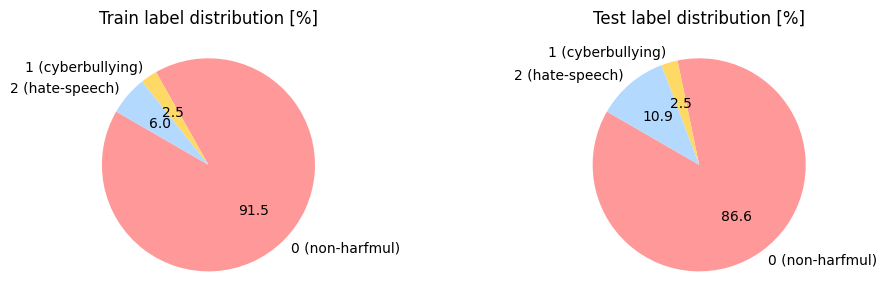

In [5]:
display_class_distribution(train_labels, test_labels)

In [6]:
len(train_labels), len(test_labels)

(10041, 1000)

Initial cleaning:

In [7]:
train_data = [text.replace("@anonymized_account", "") for text in train_data]
test_data = [text.replace("@anonymized_account", "") for text in test_data]

## Baselines

In [8]:
results = []

for model in [SVC(random_state=SEED),
              DecisionTreeClassifier(random_state=SEED),
              MultinomialNB()]:
    
    pipeline = make_pipeline(
        CountVectorizer(),
        model
    )
    result_dict = model_results(pipeline,
                                train_data, train_labels,
                                test_data, test_labels)
    results.append(result_dict)
    
pd.DataFrame(results)

,model,microF,macroF
0,SVC,0.867,0.315623
1,DecisionTreeClassifier,0.866,0.495613
2,MultinomialNB,0.866,0.326913


## Experiments with:

* class balancing
* feature extraction method and its parameters
* model type

### Class weighting

In [27]:
stop_words = get_stop_words("polish")
stemmer = StempelStemmer("polish").polimorf()
    
stem_transformer = FunctionTransformer(lambda texts:
                                       [stemmer.stem(word) for word in texts])

pipeline = Pipeline([
    ("stemmer", stem_transformer),
    ("vectorizer", CountVectorizer()),
    ("model", SVC())
])

preprocess_grid = {
    "stemmer": [stem_transformer, "passthrough"],
    "vectorizer": [CountVectorizer(), TfidfVectorizer()],
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__stop_words": [stop_words, None],
    "vectorizer__max_df": [0.8, 1.0],
    "vectorizer__min_df": [1, 3, 5, 10],
    "vectorizer__max_features": [None, 500, 1000]
}

class_weight = ["balanced", None,
                {0: 1, 1: 36, 2: 15},
                {0: 1, 1: 20, 2: 10}]

SVC_grid = {
    "model": [SVC(random_state=SEED)],
    "model__kernel": ["linear", "rbf"],
    "model__C": [0.01, 0.1, 1.0],
    "model__class_weight": class_weight
}
DecisionTree_grid = {
    "model": [DecisionTreeClassifier(random_state=SEED)],
    "model__min_samples_leaf": [5, 10, 25],
    "model__max_depth": [3, 5, 7, None],
    "model__max_features": [0.5, 0.75, None],
    "model__class_weight": class_weight
}
MultiNB_grid = {
    "model": [MultinomialNB()]
}

cv_scheme = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
names = ["SVC", "DecisionTree", "MultinomialNB"]
model_grids = [SVC_grid, DecisionTree_grid, MultiNB_grid]

Loading: 100%|██████████| 11368252/11368252 [00:06<00:00, 1807063.60bytes/s]


In [45]:
results = []

for name, model_grid in zip(names, model_grids):
    
    param_grid = {**preprocess_grid,
                  **model_grid}
    
    optimizer = RandomizedSearchCV(pipeline,
                                   param_grid,
                                   cv=cv_scheme,
                                   scoring=["f1_micro", "f1_macro"],
                                   refit="f1_micro",
                                   n_jobs=-1,
                                   n_iter=200
                                  )
    optimizer.fit(train_data, train_labels)

    best_idx = optimizer.best_index_
    cv_f1_micro = optimizer.best_score_
    cv_f1_macro = optimizer.cv_results_['mean_test_f1_macro'][best_idx][0]
    y_pred = optimizer.best_estimator_.predict(test_data)
    test_f1_micro = f1_score(test_labels, y_pred, average="micro")
    test_f1_macro = f1_score(test_labels, y_pred, average="macro")

    dict_result = {
        "model": name,
        "cv_microF": cv_f1_micro,
        "cv_macroF": cv_f1_macro,
        "test_microF": test_f1_micro,
        "test_macroF": test_f1_macro
    }
    results.append(dict_result)

pd.DataFrame(results).round(3)

,model,cv_microF,cv_macroF,test_microF,test_macroF
0,SVC,0.929,0.488,0.867,0.365
1,DecisionTree,0.916,0.348,0.868,0.338
2,MultinomialNB,0.929,0.476,0.866,0.357
